In [2]:
import numpy as np
import scipy.signal as ss
from scipy.linalg import toeplitz
import scipy.sparse.linalg as la
import matplotlib.pyplot as plt

# definindo a matriz de convolução
def convmtx(h, M):
  '''
  h: kernel
  M: operand length
  '''
  if len(h)<=M:
    col = np.concatenate([h, np.zeros(M - len(h))])
  else:
    col=h.copy()
  row = np.concatenate([[h[0]], np.zeros(M - 1)])
  result = toeplitz(col, row)

  return result

# definindo um operador linear equivalente a convmtx
def convmtx_linOp(kernel, operand_len=None):
  # dimensões da matriz de convolução:
  if operand_len is None:
    n = len(kernel)
  else:
    n = operand_len
  m = np.max((len(kernel), n))

  # condicionais para janelar corretamente a saída da conv e corr:
  if (np.minimum(len(kernel), n)-1) == 0:
    slNone = None
    slzero = 0
  else:
    slNone = -(np.minimum(len(kernel), n)-1)
    slzero = (np.minimum(len(kernel), n)-1)

  # definindo Kernel e Kernel^H
  def matvec(operand):
    return ss.convolve(kernel, operand, mode='full')[:slNone]

  def rmatvec(operand_):
    operand_pad_ = np.pad(operand_, (0, slzero))
    return ss.correlate(operand_pad_, kernel, mode = 'valid')

  return la.LinearOperator(shape=(m, n), matvec=matvec, rmatvec=rmatvec)

In [3]:
m, n = [15, 20]
operand = np.random.randn(m)
kernel = np.random.randn(n)
operand_ = np.random.randn(np.maximum(len(kernel), len(operand)))

# definindo H
H_mtx = convmtx(kernel, len(operand))
H_linOp = convmtx_linOp(kernel, len(operand))

# utilizando convmtx:
Hx_mtx = H_mtx @ operand
HTy_mtx = H_mtx.T @ operand_

# utilizando linOp:
Hx_conv = H_linOp @ operand
HTy_conv = H_linOp.T @ operand_

are_close = np.isclose(Hx_mtx, Hx_conv).all()
norm_diff = np.linalg.norm(Hx_mtx - Hx_conv)

are_close_ = np.isclose(HTy_mtx, HTy_conv).all()
norm_diff_ = np.linalg.norm(HTy_mtx - HTy_conv)
print(f'convmtx and matvec are the same: \t{are_close}; norm diff: {norm_diff}')
print(f'convmtx.T and rmatvec are the same: \t{are_close_}; norm diff: {norm_diff_}')

convmtx and matvec are the same: 	True; norm diff: 1.9133237149764433e-15
convmtx.T and rmatvec are the same: 	True; norm diff: 1.2362920382602608e-15


A implementação aplicado a um problema inverso sintetico:

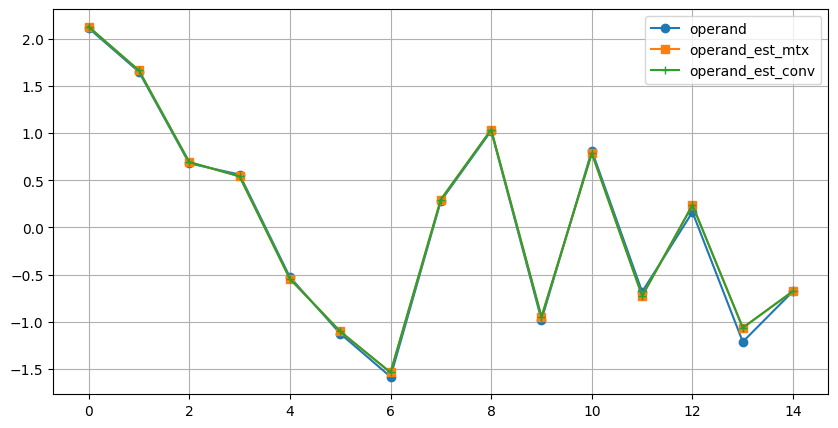

In [4]:
# Seja b igual a (Hx_mtx + Hx_conv)/2 + ruído
# A seguir verificaremos que quando resolvermos
# o problema least-squares Hx = b
# x está próximo de operand

# snr dado um ruído [dB]
snr_dB = 40
snr = 10**(snr_dB/20)

# snr = std(sig)/std(noise)

w_ = np.std(Hx_conv)*(np.random.randn(len(Hx_conv))/(snr))

b = (Hx_mtx + Hx_conv)/2 + w_

operand_est_mtx = la.lsmr(H_mtx, b)[0]
operand_est_conv = la.lsmr(H_linOp, b)[0]


plt.figure(figsize=(10, 5))
plt.plot(operand, "-o", label='operand')
plt.plot(operand_est_mtx, "-s", label='operand_est_mtx')
plt.plot(operand_est_conv, "-+", label='operand_est_conv')
plt.legend()
plt.grid()